In [1]:
library(patchwork)
library(tidyverse)
library(data.table)
library(tsibble)

-- Attaching packages ---------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.2     v purrr   0.3.4
v tibble  3.0.3     v dplyr   1.0.1
v tidyr   1.1.1     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0

-- Conflicts ------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'data.table'


The following objects are masked from 'package:dplyr':

    between, first, last


The following object is masked from 'package:purrr':

    transpose



Attaching package: 'tsibble'


The following object is masked from 'package:data.table':

    key




In [13]:
# Load files
files <- paste0("Data/", list.files("Data/", pattern = "*.csv"))

data_monthly_per_country <- map(files,
                                ~ fread(.x) %>%
                                    as_tibble()) %>%
    reduce(bind_rows) %>%
    mutate(yearmonth = yearmonth(as.Date(InvoiceDate)),
           # Combine same products with different colors
           product = str_sub(StockCode, 1, 5)) %>%
    filter(Quantity > 0,
           Price > 0,
           # Remove those without numbers in product ID
           !str_detect(product, "^[[:alpha:]]")) %>%
    group_by(yearmonth, product, Country) %>%
    # Calculate amount of sales, average prices, revenue and receipt amount
    summarise(quantity_sum = sum(Quantity, na.rm = TRUE),
              price_mean = weighted.mean(Price, Quantity, na.rm = TRUE),
              revenue = sum(Price * Quantity),
              n_receipts = n())

`summarise()` regrouping output by 'yearmonth', 'product' (override with `.groups` argument)



# Price distribution on country level

The graphs below mainly create an initial idea how prices vary across countries. We see the same pattern across different countries and the prices tend to be rightly skewed with most products priced at the lower end of the distribution. The boxplot also shows the presence of several large price points across the board. We also see the same price variation across countries for roughly the same products.

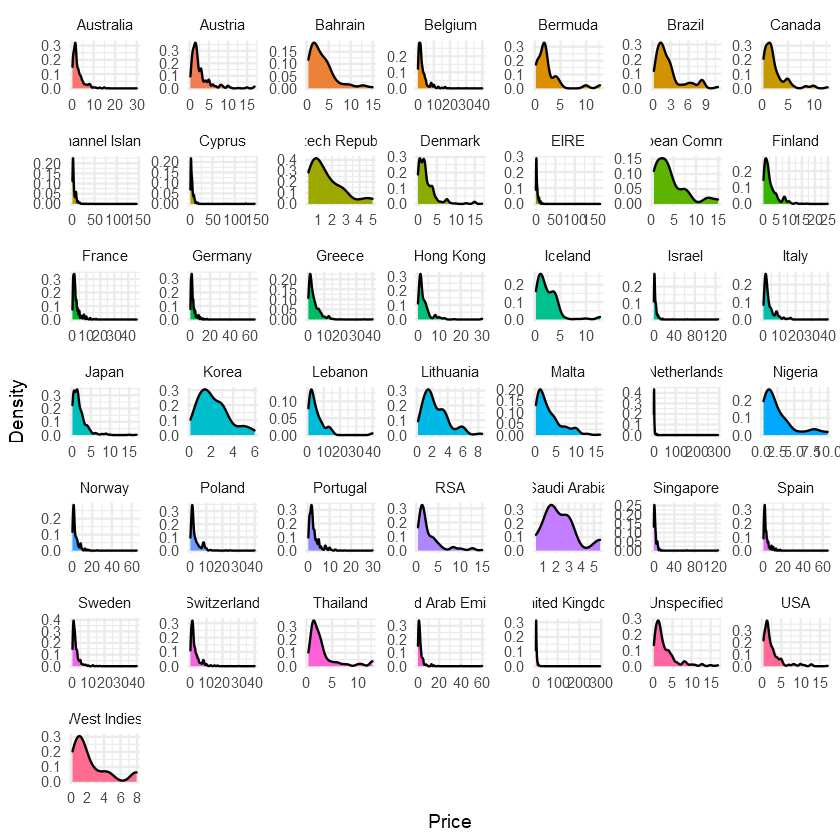

In [14]:
# Density - Free Scales
data_monthly_per_country %>%
  ggplot(aes(x = price_mean, fill = Country)) +
  geom_density() +
  facet_wrap(~ Country, scales = "free") +
  theme_minimal() +
  xlab("Price") +
  ylab("Density") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5),
        legend.position = "none")

Warning message:
"Removed 38 rows containing non-finite values (stat_boxplot)."


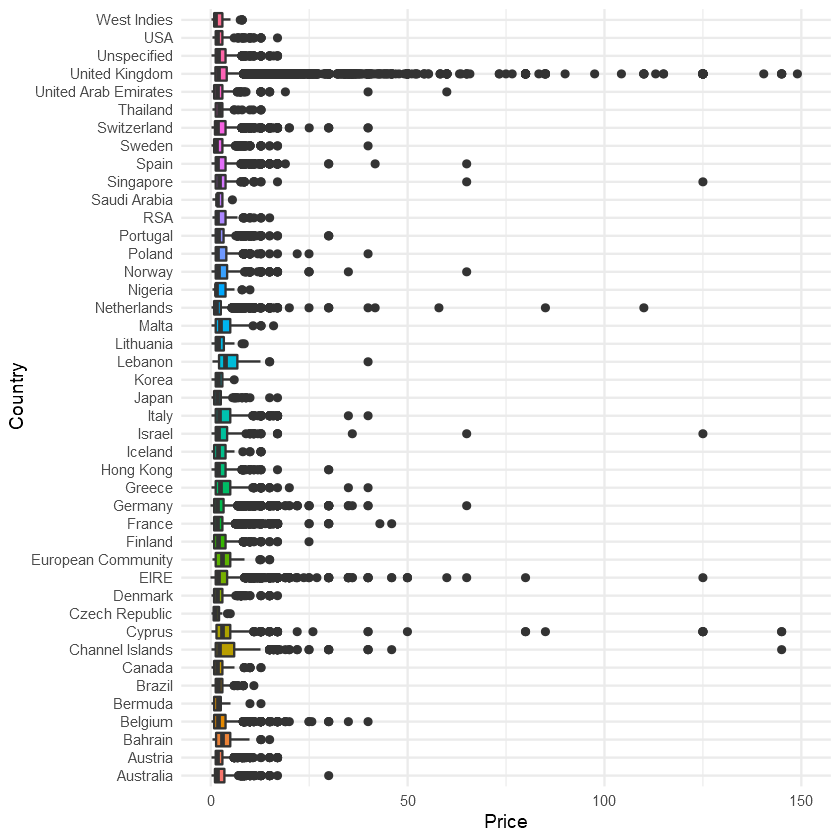

In [15]:
# Box plot
data_monthly_per_country %>%
  ggplot(aes(x = Country, y = price_mean, fill = Country)) +
  geom_boxplot() +
  theme_minimal() +
  xlab("Country") +
  ylab("Price") +
  ylim(0, 150) +
  theme_minimal() +
  coord_flip() + 
  theme(plot.title = element_text(hjust = 0.5),
        legend.position = "none")

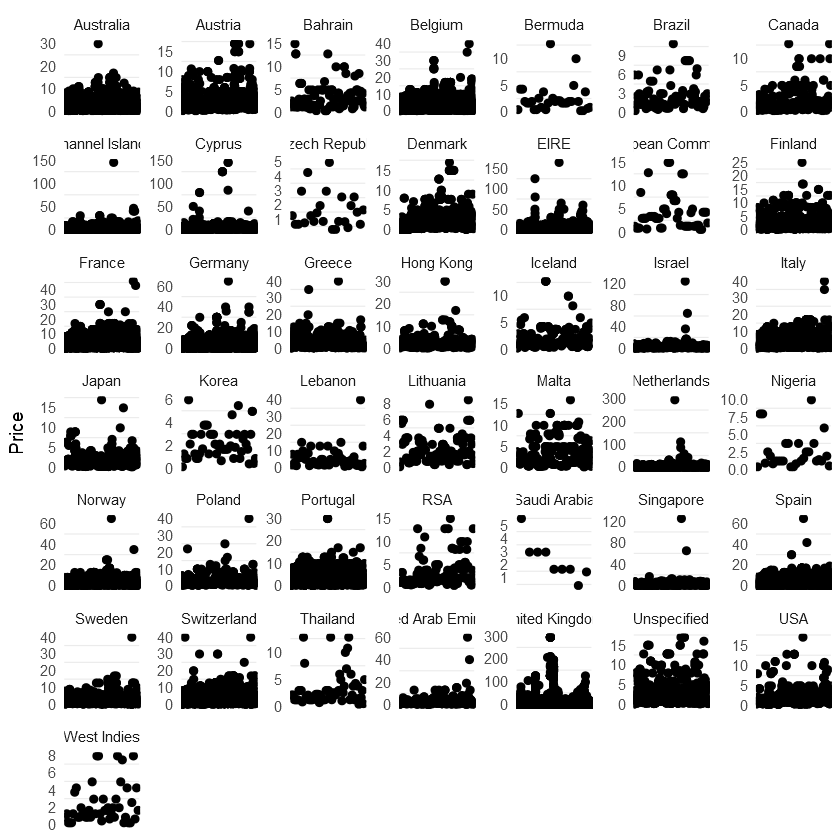

In [16]:
# Price Variation within Country and Product
data_monthly_per_country %>%
  ggplot(aes(x = product, y = price_mean)) +
  geom_point() +
  facet_wrap(~ Country, scales = "free") +
  xlab("Products") +
  ylab("Price") +
  theme_minimal() +
  theme(panel.grid.major = element_blank(),
        axis.title.x = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        plot.title = element_text(hjust = 0.5))

In [18]:
# Remove country level
data_monthly <- data_monthly_per_country %>%
    group_by(yearmonth, product) %>%
    # Calculate amount of sales, average prices, revenue and receipt amount
    summarise(price_mean = weighted.mean(price_mean, quantity_sum, na.rm = TRUE),
              revenue = sum(revenue),
              n_receipts = sum(n_receipts))

`summarise()` regrouping output by 'yearmonth' (override with `.groups` argument)



# Price distribution in general

In this section we see how prices vary across single products alone by ignoring the country dimension. As seen earlier, products behave similarly across countries, which is expected as the data concerns an online store. The aggregated data shows similar patterns as before, with a right skew in the price distribution with the presence of several outliers on the right end.

Warning message:
"Removed 542 rows containing non-finite values (stat_density)."


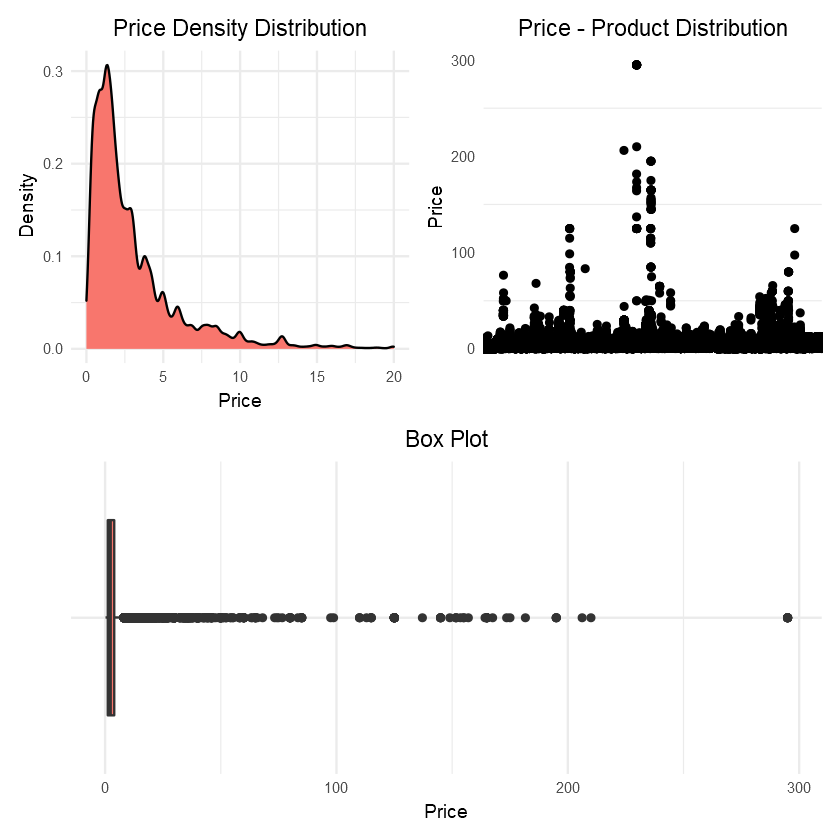

In [26]:
# Density
p1 <- data_monthly %>%
  ggplot(aes(x = price_mean, fill = "gray")) +
  geom_density() +
  theme_minimal() +
  xlim(0, 20) +
  xlab("Price") +
  ylab("Density") +
  ggtitle("Price Density Distribution") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5),
        legend.position = "none")

# Price Variation within product
p2 <- data_monthly %>%
  ggplot(aes(x = product, y = price_mean)) +
  geom_point() +
  xlab("Products") +
  ylab("Price") +
  theme_minimal() +
  theme(panel.grid.major = element_blank(),
        axis.title.x = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank()) +
  ggtitle("Price - Product Distribution") +
  theme(plot.title = element_text(hjust = 0.5))

# Box plot
p3 <- data_monthly %>%
  ggplot(aes(x = "", y = price_mean, fill = "red")) +
  geom_boxplot() +
  theme_minimal() +
  xlab("") +
  ylab("Price") +
  ggtitle("Box Plot") +
  theme_minimal() +
  coord_flip() +
  theme(plot.title = element_text(hjust = 0.5),
        legend.position = "none")

(p1 + p2) / p3

# Time horizon and aggregation 

As the data is going to be used in modeling an optimal price for a forecasting horizon, it is important to have enough data points and to account for potential outliers. We use ARIMA as the modeling tool, so a product needs to have at least 24 months’ worth of data in order to be considered. As we see in the table below only 4 countries do have products with at least 24 months and almost all of them are in the UK. Since we deal with the same products across countries and we do not have enough data to carry an analysis across countries we decide to collapse the data by not taking the country into account, obtaining (weighted) average prices on monthly levels. This makes also makes sense, since you could expect the sales of the website to behave quite similarly across countries, unlike in the situation where the store was a brick-and-mortar store. Products showing significant breaks are filtered out before the modeling.

In [28]:
# At least 24 months
data_monthly_per_country %>%
  group_by(product, Country) %>% 
  # Keep only products with two years of observations or more
  mutate(n_months = n()) %>% 
  filter(n_months >= 24) %>%
  group_by(Country) %>%
  summarise(Count = n()) %>%
  ungroup() %>%
  mutate(Percentage = paste0(100 * (round(Count / sum(Count) , 4)), "%"))

`summarise()` ungrouping output (override with `.groups` argument)



Country,Count,Percentage
<chr>,<int>,<chr>
EIRE,49,0.22%
France,269,1.22%
Germany,197,0.9%
United Kingdom,21496,97.66%
